# Medical Appointment No Shows


We use the [joniarroba/noshowappointments](https://www.kaggle.com/datasets/joniarroba/noshowappointments/code) dataset to analyze the different implementations of neural network mentioned above

Refer to report for code explanation

In [ ]:
import pandas as pd

df = pd.read_csv("medical-no-show.csv", parse_dates=["ScheduledDay", "AppointmentDay"])
df.rename(columns={"Hipertension": "Hypertension", "Handcap": "Handicap", "No-show": "no_show"}, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_noshow = LabelEncoder()
df["no_show"] = le_noshow.fit_transform(df["no_show"])

le_gender = LabelEncoder()
df["Gender"] = le_gender.fit_transform(df["Gender"])

In [ ]:
df["days_waited"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days
df["appointment_weekday"] = df["AppointmentDay"].dt.weekday

In [ ]:
df = df[df['Age'] >= 0]
df = df[df['days_waited'] >= 0]

In [ ]:
patient_missed_before = df.groupby("PatientId")["no_show"].sum()
patient_missed_before = patient_missed_before.to_dict()

df["missed_appointment_before"] = df["PatientId"].map(lambda x: patient_missed_before.get(x) > 0)
df["times_missed_before"] = df["PatientId"].map(lambda x: patient_missed_before.get(x))

In [ ]:
sorted_neighbourhoods = df.groupby("Neighbourhood")["no_show"].sum().sort_values()

df["neighbourhood_weight"] = df["Neighbourhood"].map(lambda x: sorted_neighbourhoods.index.to_list().index(x))

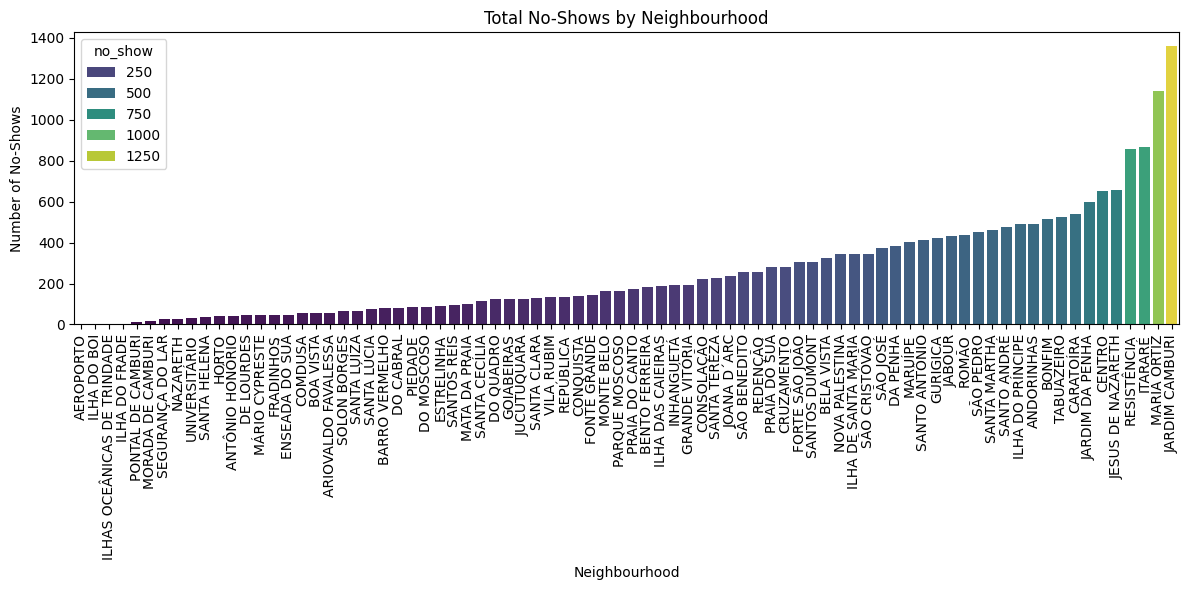

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

no_shows_df = sorted_neighbourhoods.reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=no_shows_df, x="Neighbourhood", y="no_show", hue="no_show", palette="viridis")

# Rotate x labels if too many Neighbourhoods
plt.xticks(rotation=90)
plt.title("Total No-Shows by Neighbourhood")
plt.xlabel("Neighbourhood")
plt.ylabel("Number of No-Shows")
plt.tight_layout()
plt.show()

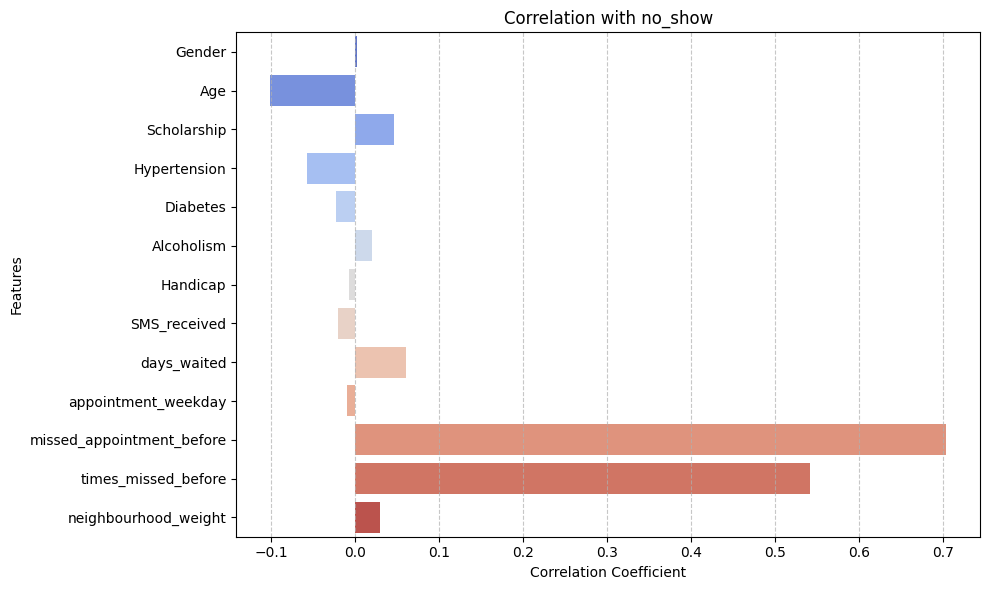

In [ ]:
correlation = df.drop(columns=["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Neighbourhood"]).corrwith(df["no_show"]).drop("no_show")

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, hue=correlation.index, palette="coolwarm")

plt.title("Correlation with no_show")
plt.ylabel("Features")
plt.xlabel("Correlation Coefficient")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Neighbourhood", "no_show"])
y = df["no_show"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64763, 13), (64763,), (7196, 13), (7196,))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
pd.DataFrame(x_train, columns=x.columns).sample(2)

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,days_waited,appointment_weekday,missed_appointment_before,times_missed_before,neighbourhood_weight
50935,-0.704414,0.806656,-0.318687,-0.514471,-0.283471,-0.162492,-0.129959,1.014668,0.264611,-0.638485,1.112025,1.307716,0.290495
24097,1.419619,0.283503,-0.318687,-0.514471,-0.283471,-0.162492,-0.129959,1.014668,0.507202,-1.368037,1.112025,0.318027,0.120750


# Solved using torch

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def metrics(y_true, y_hat):
    # Convert y_hat (probability) to 0(<0.5) to 1(>0.5)
    y_pred = np.where(y_hat > .5, 1, 0)

    accuracy = accuracy_score(y_true, y_pred) # Accuracy Score
    f1 = f1_score(y_true, y_pred) # F1 Score
    cm = confusion_matrix(y_true, y_pred) # Confusion Matrix

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_hat)
    pr_auc = auc(recall, precision)

    return {
        "accuracy": accuracy, "pr_auc": pr_auc,
        "f1_score": f1, "confusion_matrix": cm
    }

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from memory_profiler import memory_usage

# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()


        self.model = nn.Sequential(
            nn.Linear(input_dim, 10), # 10 nodes
            nn.ReLU(),

            nn.Linear(10, 1), # one node
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = BinaryClassifier(input_dim=x_train.shape[1])

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

history_torch = []
counter_torch = 0
time_start = time.time()

for epoch in range(1):
    model.train()

    for xi, yi in zip(x_train_tensor, y_train_tensor):
        if counter_torch % 200 == 0:
            cost = criterion(model(x_test_tensor), y_test_tensor).item()
            history_torch.append([counter_torch / 200, cost,
                                  time.time()-time_start])
        counter_torch = counter_torch + 1

        optimizer.zero_grad() # Making gradient zero

        loss = criterion(model(xi), yi)
        loss.backward()

        optimizer.step()

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_preds = model(x_test_tensor).detach().numpy()

metrics_pytorch = metrics(y_test, y_preds)
print(f'time: {history_torch[-1][2]}')
print(metrics_pytorch)

time: 59.75654602050781
{'accuracy': 0.8394941634241245, 'pr_auc': np.float64(0.7375674315889363), 'f1_score': 0.7671840354767184, 'confusion_matrix': array([[4138, 1036],
       [ 119, 1903]])}


# Solved using core implementation

In [ ]:
class Layer:
    def __init__(self, activation, units):
        self.activation = activation
        self.units = units # Number of nodes

        self.z = None # Pre-Activation
        self.a = None # Activated

        self.weights = None
        self.bias = None

    def activation_function(self, xi):
        if self.activation == "relu":
            return np.maximum(0, xi)

        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-xi))

    def activation_derivative(self, xi):
        if self.activation == "relu":
            return (xi > 0).astype(float)

        elif self.activation == "sigmoid":
            sig = self.activation_function(xi)
            return sig * (1 - sig)

    def forward(self, xi):
        self.z = np.dot(self.weights, xi) + self.bias
        self.a = self.activation_function(self.z)

        return self.a

In [ ]:
layer_1 = Layer(units=10, activation="relu")   # Hidden Layer
layer_2 = Layer(units=1, activation="sigmoid") # Output Layer

In [ ]:
import time

class Model:
    def __init__(self, layers, input_features):
        self.layers = layers # List of layers in the model
        self.input_features = input_features # Number of inputs

        self.compiled = False
        self.metrics = False # To show metrics after each epochs

        self.learning_rate = 0.01 # Learning rate of the model

    def compile(self, metrics=False):
        for layer_i in range(len(self.layers)):
            layer = self.layers[layer_i]

            fan_in = self.input_features if layer_i == 0 else self.layers[layer_i - 1].units

            # He initialization
            if layer.activation == "relu":
                layer.weights = np.random.randn(layer.units, fan_in) *
                                            np.sqrt(2. / fan_in)

            # Xavier initialization
            elif layer.activation == "sigmoid":
                layer.weights = np.random.randn(layer.units, fan_in) *
                                            np.sqrt(1. / fan_in)

            # Default small random values
            else:
                layer.weights = np.random.randn(layer.units, fan_in) * 0.01


            # Biases initialized to zero
            layer.bias = np.zeros((layer.units, 1))

        self.compiled = True
        self.metrics = metrics

    def summary(self):
        total_trainable_parameters = 0

        for layer_i in range(len(self.layers)):
            layer = self.layers[layer_i]
            layer_trainable_parameters = self.input_features * layer.units
            total_trainable_parameters += layer_trainable_parameters

            print(" " * 16, f"Layer: {layer_i + 1}")
            print(f"Units: {layer.units}")
            print(f"Activation: {layer.activation}")
            print(f"Trainable Parameters: {layer_trainable_parameters}")
            print("=" * 40)

        print(f"Total Trainable Parameters: {total_trainable_parameters}")
        print("=" * 40, "\n")

    def predict(self, x_test):
        if self.compiled:
            y_pred = []

            for xi in x_test: # different cases
                for i in range(len(self.layers)):
                    xi = self.layers[i].forward(xi.reshape(-1, 1))

                y_pred.append(xi[0][0])

            return np.array(y_pred)

        else: print("Model is not yet compiled")

    def loss_calculate(self, yi_true, yi_pred):
        yi_pred = yi_pred + (1e-8) # Handling 0 case

        return -1 * np.mean(
            (yi_true * np.log(yi_pred)) +
            ((1 - yi_true) * np.log(1 - yi_pred))
        )

    def fit(self, x_train, y_train, val_data, epochs=1,learning_rate=0.01):
        self.learning_rate = learning_rate
        history_core = []
        counter_core = 0
        time_start = time.time()

        for epoch in range(epochs):
            for xi, yi in zip(x_train, y_train):
                if counter_core % 200 == 0:
                    cost = self.loss_calculate(val_data[1],
                                               self.predict(val_data[0]))
                    history_core.append([counter_core / 200, cost,
                                         time.time()-time_start])
                counter_core = counter_core + 1

                yi_pred = (self.predict([xi]))[0]
                loss = self.loss_calculate(yi, yi_pred)

                z1, a1 = self.layers[0].z, self.layers[0].a
                yi_pred = yi_pred + (1e-8) # Handling 0 case

                # Calculating derivatives (discussed in 5.1.5)
                dl_dy_hat = -1 * (yi/yi_pred - (1 - yi)/(1 - yi_pred))
                dy_hat_dz2 = yi_pred * (1 - yi_pred)
                dz2_dw2 = a1.T
                dz2_db2 = 1
                dz2_dw1 = self.layers[1].weights.T * xi *
                          self.layers[0].activation_derivative(z1)
                dz2_db1 = self.layers[0].activation_derivative(z1)


                """
                Calculating partial derivatives of loss wrt weight/bias
                Layer 1, and 2
                """
                dl_dw1 = np.array(dl_dy_hat * dy_hat_dz2 * dz2_dw1)
                dl_db1 = np.array(dl_dy_hat * dy_hat_dz2 * dz2_db1)
                dl_dw2 = np.array(dl_dy_hat * dy_hat_dz2 * dz2_dw2)
                dl_db2 = np.array(dl_dy_hat * dy_hat_dz2 * dz2_db2)

                # Updating weights, and biases for Layer 1, and 2
                self.layers[1].weights -= self.learning_rate * dl_dw2
                self.layers[1].bias -= self.learning_rate * dl_db2
                self.layers[0].weights -= self.learning_rate * dl_dw1
                self.layers[0].bias -= self.learning_rate * dl_db1

            metrics_core = metrics(val_data[1], self.predict(val_data[0]))

            if self.metrics: # Print metrics for each epoch
                print(f"Epoch: {epoch+1}, metrics: {metrics_core}")

        return (metrics_core, history_core)

In [ ]:
custom_model = Model(layers=[layer_1, layer_2], input_features=x_train.shape[1])

custom_model.summary()
custom_model.compile(metrics=True)

                 Layer: 1
Units: 10
Activation: relu
Trainable Parameters: 130
                 Layer: 2
Units: 1
Activation: sigmoid
Trainable Parameters: 13
Total Trainable Parameters: 143



In [ ]:
metrics_core, history_core = custom_model.fit(x_train, y_train, val_data=(x_test, y_test))

Epoch 1, {'accuracy': 0.839633129516398, 'pr_auc': np.float64(0.7351733437905972), 'f1_score': 0.7565400843881857, 'confusion_matrix': array([[4249,  925],
       [ 229, 1793]])}


In [ ]:
print(f"time: {history_core[-1][2]}, metrics: {metrics_core}")

time: 70.22289705276489, metrics: {'accuracy': 0.839633129516398, 'pr_auc': np.float64(0.7351733437905972), 'f1_score': 0.7565400843881857, 'confusion_matrix': array([[4249,  925],
       [ 229, 1793]])}


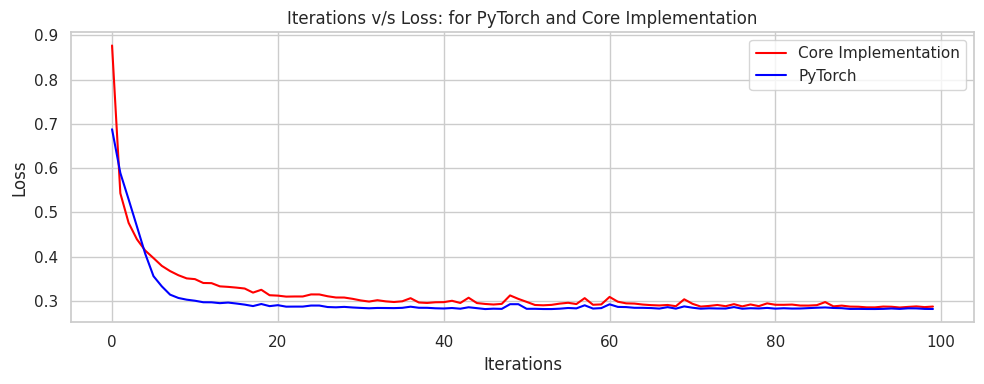

In [ ]:
sns.set(style="whitegrid") # style to show grid

history_core = np.array(history_core)   # convert to numpy array
history_torch = np.array(history_torch) # convert to numpy array

plt.figure(figsize=(10, 4))

sns.lineplot(x=history_core[:100, 0], y=history_core[:100, 1],
             color="red", label="Core Implementation") # Core
sns.lineplot(x=history_torch[:100, 0], y=history_torch[:100, 1],
             color="blue", label="PyTorch")            # PyTorch

plt.title("Iterations v/s Loss: for PyTorch and Core Implementation")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

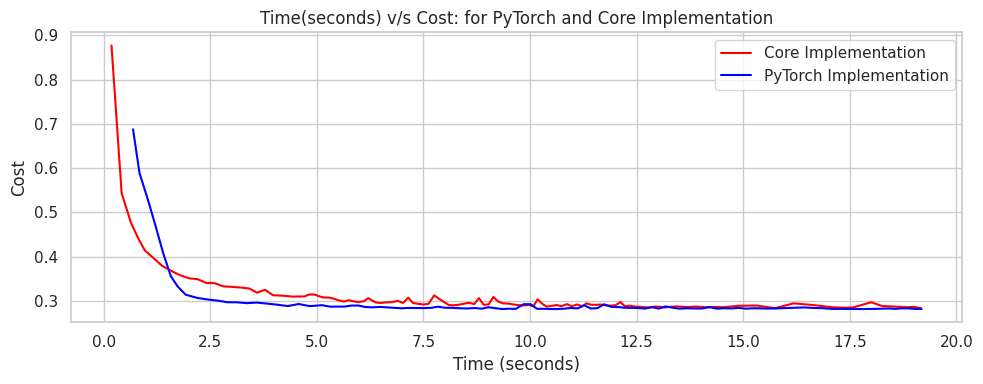

In [ ]:
sns.set(style="whitegrid") # style to show grid

history_core = np.array(history_core)   # convert to numpy array
history_torch = np.array(history_torch) # convert to numpy array

plt.figure(figsize=(10, 4)) # set figure size

# Red Line for Core Implementation
sns.lineplot(x=history_core[:117, 2], y=history_core[:117, 1],
             color="red", label="Core Implementation")

# Blue Line for PyTorch Implementation
sns.lineplot(x=history_torch[:100, 2], y=history_torch[:100, 1],
             color="blue", label="PyTorch Implementation")

plt.xlabel("Time (seconds)")
plt.ylabel("Cost")
plt.title("Time(seconds) v/s Cost: for PyTorch and Core Implementation")

plt.tight_layout()
plt.show()

|impl|accuracy|f1 score|pr auc|
|:-:|:-:|:-:|:-:|
|torch|0.84|0.77|0.74|
|core|0.84|0.76|0.73|

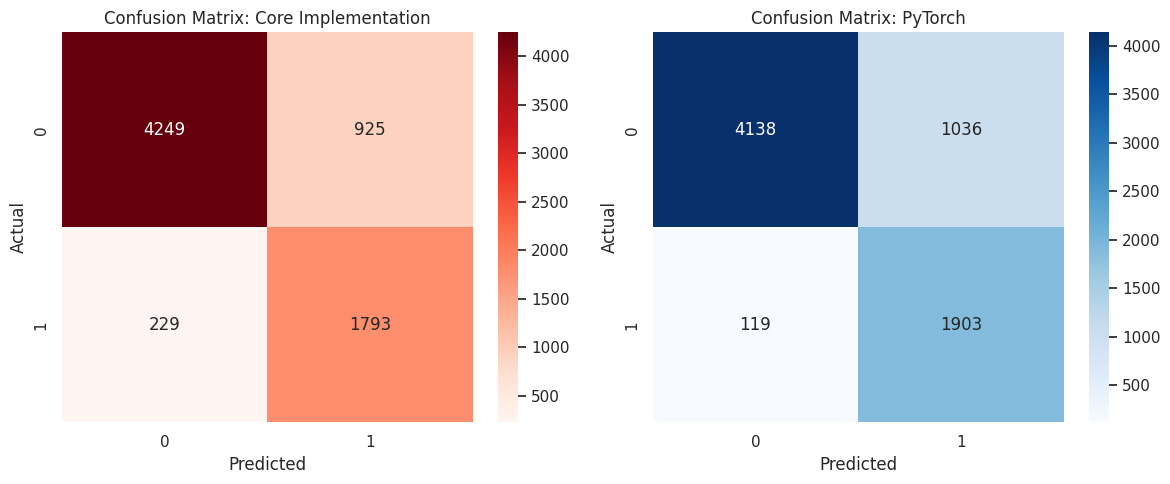

In [ ]:
# Plot 2 graphs on same axis, with required size
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for both implementation
cm_core = metrics_core["confusion_matrix"]
cm_torch = metrics_pytorch["confusion_matrix"]

# Plotting graph for Core Implementation
sns.heatmap(cm_core, annot=True, fmt="d", cmap="Reds", ax=axs[0])
axs[0].set_title("Confusion Matrix: Core Implementation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# Plotting graph for PyTorch Implementation
sns.heatmap(cm_torch, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix: PyTorch")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()